# 1. Introduction

## Goal of project

The goal of this project is to:
* Predict house price based on generalized linear regression models, including linear regression and its penalized versions, ridge, lasso, and eleastic net.
* Use feature engineering techniques to improve model (= minimize cost function RMSE, where the base line model is 0.14)

## Result of project

* Final regression model chosen: lasso
* Best local RMSE result:
* kaggle id: jk6653284
* Best kaggle RMSE result: 0.11977
* kaggle ranking: 733

# 2. Workspace setting: libraries and data reading

In [216]:
# import libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option("max_columns", None)
%matplotlib inline

In [217]:
# read in data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [218]:
# view shape, structure, and the first few columns of training set
print("{} observations and {} variables".format(train.shape[0], train.shape[1]))
print("\n")
print(train.info())

1460 observations and 81 variables


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-nu

In [219]:
# view shape, structure, and the first few columns of test set
print("{} observations and {} variables".format(test.shape[0], test.shape[1]))
print("\n")
print(test.info())

1459 observations and 80 variables


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-n

The variables can be divided into the following major sections:

* **Id**: unique identifier
* **Area information**: information on where the property is located, such as neighborhood
* **Property information**: information on property itself, such as street, alley, or the lot 
* **External information**: property's external information such as foundation or roof
* **Basement information**: basement related information
* **Utilities**: other utilities such as heating, electricity, or pool
* **Internal**: internal space information such as rooms or kitchen
* **Garage**: garage related information
* **Sales information**: sales specific information such as condition or sales date

# 3. Data Cleaning

Since both training and test set need to be cleaned, I will concatenate the training and test set for now and later split them before modeling.

In [220]:
# store training and test id
train_id = train.Id.tolist()
test_id = test.Id.tolist()

# concat train and test set
full_df = pd.concat([train,test])

## NA Values

I used different NA filling methods for different variables, such as mean or median, using mode from similar listings, or simply imputing with 'no'.

In [221]:
# check for null values for each column
full_df.isnull().sum()[full_df.isnull().sum() > 0]

Alley           2721
BsmtCond          82
BsmtExposure      82
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      79
BsmtFinType2      80
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          81
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2348
FireplaceQu     1420
Functional         2
GarageArea         1
GarageCars         1
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
MiscFeature     2814
PoolQC          2909
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

### NA: Area and property variables

In [222]:
# exterior 1st and 2nd
# fill in based on housestyle
full_df.groupby("HouseStyle")['Exterior1st'].value_counts()

# impute with VinylSd
full_df.loc[full_df.Exterior1st.isnull(), ['Exterior1st','Exterior2nd']] = 'VinylSd'

In [223]:
# functional 
# most are typical unless deductions are warranted: impute with mode
full_df.loc[full_df.Functional.isnull(), 'Functional'] = 'Typ'

In [224]:
# MSZoning
# zoning should be very dependent on neighbourhood and housestlye
full_df.loc[(full_df.Neighborhood == 'IDOTRR') & (full_df.MSZoning == 'C (all)'), 'HouseStyle'].value_counts()
full_df.loc[(full_df.Neighborhood == 'IDOTRR') & (full_df.MSZoning == 'RM'), 'HouseStyle'].value_counts()

# impute based on mode value
full_df.loc[full_df.Id == 1916, 'MSZoning'] = 'RM'
full_df.loc[full_df.Id == 2217, 'MSZoning'] = 'C (all)'
full_df.loc[full_df.Id == 2251, 'MSZoning'] = 'RM'
full_df.loc[full_df.Id == 2905, 'MSZoning'] = 'RL'

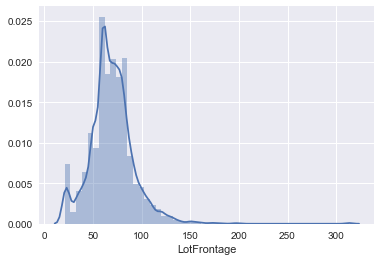

In [225]:
# LotFrontage
# view distribution
sns.distplot(full_df[full_df['LotFrontage'].notnull()].LotFrontage)

In [226]:
# because the distribution is skewed positively,
# we should use median instead of mean value to ipmute the LotFrontage values
# Neighborhood should also influence the lot size, so use it as reference

full_df["LotFrontage"] = full_df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [227]:
# Alley
# null values for alley have no alleys: impute with "no"

full_df.loc[full_df.Alley.isnull(),'Alley'] = 'no'

In [228]:
# MasVnrType and MasVnrArea
# by definition, those with 0 area should be a none type
# by the same definition, those with none type should be area 0
# change these values
full_df.loc[(full_df.MasVnrArea == 0) & (full_df.MasVnrType != 'None'), 'MasVnrType'] = 'None'
full_df.loc[(full_df.MasVnrArea != 0) & (full_df.MasVnrType == 'None'),'MasVnrArea'] = 0

# masvnrtype already has 'None' values defined
# so fill the null values as 'None'
full_df.loc[full_df.MasVnrArea.isnull(),'MasVnrArea'] = 0.0
full_df.loc[full_df.MasVnrType.isnull(),'MasVnrType'] = 'None'

### NA: Internal variables

In [229]:
# Kitchen Quality
# impute with mode value
full_df.loc[full_df.KitchenQual.isnull(), 'KitchenQual'] = 'TA'

### NA: Basement

In [230]:
# most null values don't have basement
# impute with appropriate values ('no' or 0.0)

full_df.loc[full_df.BsmtFinType1.isnull(),'BsmtFinType1'] = 'no'
full_df.loc[full_df.BsmtFinSF1.isnull(),'BsmtFinSF1'] = 0.0
full_df.loc[full_df.BsmtFinSF2.isnull(),'BsmtFinSF2'] = 0.0
full_df.loc[full_df.BsmtUnfSF.isnull(),'BsmtUnfSF'] = 0.0
full_df.loc[full_df.TotalBsmtSF.isnull(),'TotalBsmtSF'] = 0.0
full_df.loc[full_df.BsmtFullBath.isnull(),'BsmtFullBath'] = 'no'
full_df.loc[full_df.BsmtFullBath.isnull(),'BsmtFullBath'] = 0.0
full_df.loc[full_df.BsmtHalfBath.isnull(),'BsmtHalfBath'] = 0.0
full_df.loc[(full_df.BsmtQual.isnull()) & (full_df['BsmtCond'].isnull()),['BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtQual']] = 'no'

In [231]:
# overallcondition will reflect basement conditions too
# also, basement exposure will have some impact on its condition
# find the mode basment condition value gruoped by the 2 variables
full_df.groupby(['OverallCond',"BsmtExposure"])['BsmtCond'].value_counts()

# impute based on the mode values
full_df.loc[full_df.Id == 2041,'BsmtCond'] = 'TA'
full_df.loc[full_df.Id == 2186,'BsmtCond'] = 'Po'
full_df.loc[full_df.Id == 2525,'BsmtCond'] = 'TA'

In [232]:
# BsmtExposure: get mode value based on condition and housetyle
full_df.groupby(["BsmtCond",'HouseStyle'])['BsmtExposure'].value_counts()

# impute based on result
full_df.loc[full_df.BsmtExposure.isnull(),'BsmtExposure'] = 'no'

In [233]:
# impute based on BsmtFinType1 mode value
full_df.groupby("BsmtFinType1")['BsmtFinType2'].value_counts()

full_df.loc[full_df.BsmtFinType2.isnull(),'BsmtFinType2'] = 'Unf'

In [234]:
# BsmtQual is the height of basement,
# and thus should depend the bldgtype or housestlye
# impute based on mode(common) values

full_df.groupby(["BldgType","HouseStyle"])['BsmtQual'].value_counts()

full_df.loc[full_df.Id == 2218, 'BsmtQual'] = 'Gd'
full_df.loc[full_df.Id == 2219, 'BsmtQual'] = 'TA'

#### NA: Garage

In [235]:
# those with null value in garagetype have no garage
# impute with 'no'
full_df.loc[full_df.GarageType.isnull(),'GarageType'] = 'no'

In [236]:
# other garage conditions should also be filled with 'no'
# just to make sure, change values based on garagetype

full_df.loc[full_df.GarageType == 'no_garage','GarageCond'] = 'no'
full_df.loc[full_df.GarageType == 'no_garage','GarageFinish'] = 'no'
full_df.loc[full_df.GarageType == 'no_garage','GarageFinish'] = 'no'
full_df.loc[full_df.GarageType == 'no_garage','GarageQual'] = 'no'
full_df.loc[full_df.GarageType == 'no_garage','GarageYrBlt'] = 0.0

In [237]:
# there are still some garages with missing garage values
# for those garagetypes that has a garage
# impute it with mode value based on garagetype

full_df.groupby("GarageType")['GarageCond'].value_counts()
full_df.loc[(full_df.GarageCond.isnull()), 'GarageCond'] = 'TA'

In [238]:
# impute Garage cars with garagetype median value
full_df[full_df.GarageType == 'Detchd']['GarageCars'].describe()
full_df.loc[full_df.GarageCars.isnull(), 'GarageCars'] = 2.0

In [239]:
# garagearea
full_df.groupby(["GarageType", 'Neighborhood'])['GarageArea'].describe()

# impute with median value for garagetype and neighborhood
full_df.loc[full_df.GarageArea.isnull(),'GarageArea'] = full_df.loc[(full_df.GarageType =='Detchd') & (full_df.Neighborhood == 'IDOTRR'),'GarageArea'].median()

In [240]:
# GarageFinish
# insert both by common values

full_df.groupby(["GarageType","HouseStyle"])['GarageFinish'].value_counts()
full_df.loc[full_df.GarageFinish.isnull(), 'GarageFinish'] = 'Unf'

In [241]:
# GarageYrBlt
# impute by 'YearRemodAdd' value
full_df.loc[full_df.GarageYrBlt.isnull(),'GarageYrBlt'] = full_df.loc[full_df.GarageYrBlt.isnull(),'YearRemodAdd']

In [242]:
# GarageQual
# should depend on garagecondition and finish
full_df.groupby(["GarageCond", "GarageFinish"])['GarageQual'].value_counts()

# impute based on value
full_df.loc[full_df.GarageQual.isnull(),'GarageQual'] = 'TA'

#### NA: Utilities

In [243]:
# Electrical
full_df.groupby("Electrical")['YearBuilt'].describe()

# it seems that all houses built after 1960 are "SBrkr" system
# impute the missing value with the value
full_df.loc[full_df.Electrical.isnull(), 'Electrical'] = 'SBrkr'

In [244]:
# Utilities
# most usually have allpub, so impute with mode value
full_df.groupby("Neighborhood")['Utilities'].value_counts()

full_df.loc[full_df.Utilities.isnull(),'Utilities'] = 'AllPub'

In [245]:
# Fireplaces and FireplaceQu
# impute all null values with "no_fireplace"
full_df.loc[full_df.FireplaceQu.isnull(),'FireplaceQu'] = 'no'

In [246]:
# Fence
# fences NA = no fence
full_df.loc[full_df.Fence.isnull(),'Fence'] = 'no'

In [247]:
# MiscFeature
# fill null miscfeatures with 'no_miscfeat'
full_df.loc[full_df.MiscFeature.isnull(),'MiscFeature'] = 'no'

In [248]:
# poolqc: NaN values have no pool by definition
# verify this fact by confirming that NaN QC rows have pool area = 0

# there are some pools that doesn't have pool quality info yet
# pool size is not 0
full_df[(full_df.PoolArea != 0) & (full_df.PoolQC.isnull())]

# buildings with good pool usually have other amenity conditions
# as good too
full_df.groupby("PoolQC")[['OverallQual']].describe()
full_df.groupby("PoolQC")[['KitchenQual']].describe()
full_df.groupby("PoolQC")[['HeatingQC']].describe()

# impute based on other qualities
full_df.loc[full_df.Id == 2421,'PoolQC'] = 'Fa'
full_df.loc[full_df.Id == 2504,'PoolQC'] = 'Gd'
full_df.loc[full_df.Id == 2600,'PoolQC'] = 'Fa'

# all others should be imputed as NA
full_df.loc[full_df.PoolQC.isnull(),'PoolQC'] = 'no'

In [249]:
# saletype -> assume 'other'
full_df.loc[full_df['SaleType'].isnull(),'SaleType'] = 'Other'

In [250]:
# check for null values
full_df.isnull().sum()[full_df.isnull().sum() > 0]

SalePrice    1459
dtype: int64

## Outlier and faulty values

### Outliers

Since we are going to use linear regression and the regularized versions of it to predict the sales price, it is important that there are no outliers that affect the overall relationship between the predictor variable and the sales price. Thus, some points will need to go away based on outlier status. We only conduct outlier detection in training data so that we don't drop any test rows.

In [251]:
# define function that builds the scatterplot
# df with saleprice
full_df_train = full_df[full_df.SalePrice.notnull()]
def plot_vs_sp(colname):
    sns.regplot(data = full_df_train,x = colname,y = 'SalePrice')

In [252]:
# print train shape before dropping values
print("There are {} observations in the training set before dropping outliers.".format(full_df_train.shape[0]))

There are 1460 observations in the training set before dropping outliers.


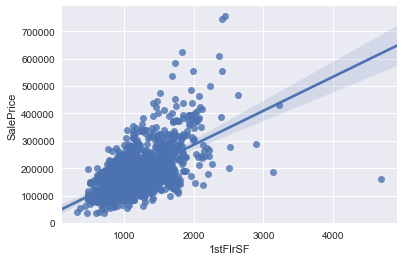

In [253]:
# 1st Flr SF
plot_vs_sp("1stFlrSF")

In [254]:
# get rid of 1stFlrSF outlier
full_df_train = full_df_train[full_df_train['1stFlrSF'] < 4000]

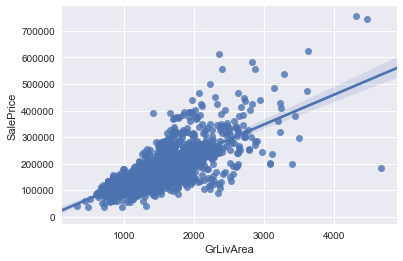

In [255]:
# GrLivArea
plot_vs_sp("GrLivArea")

In [256]:
# get rid of outlier
full_df_train[(full_df_train['GrLivArea'] > 4000) & (full_df_train['SalePrice'] < 2.55)].Id
full_df_train = full_df_train.loc[full_df_train.Id != 524,]

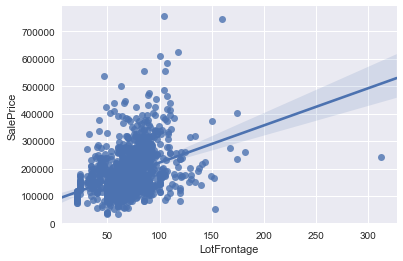

In [257]:
plot_vs_sp("LotFrontage")

In [258]:
# get rid of that single outlier
full_df_train = full_df_train.loc[full_df_train.LotFrontage < 300,]

### Faulty values

In [259]:
# years should be before 2010 and after reasonable year
print(full_df.YrSold.describe())
print('\n')
print(full_df.YearBuilt.describe())
print('\n')
print(full_df.YearRemodAdd.describe())
print('\n')
print(full_df[(full_df.GarageYrBlt != 0) & (full_df.GarageYrBlt.notnull())].GarageYrBlt.astype(int).describe())

count    2919.000000
mean     2007.792737
std         1.314964
min      2006.000000
25%      2007.000000
50%      2008.000000
75%      2009.000000
max      2010.000000
Name: YrSold, dtype: float64


count    2919.000000
mean     1971.312778
std        30.291442
min      1872.000000
25%      1953.500000
50%      1973.000000
75%      2001.000000
max      2010.000000
Name: YearBuilt, dtype: float64


count    2919.000000
mean     1984.264474
std        20.894344
min      1950.000000
25%      1965.000000
50%      1993.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64


count    2919.000000
mean     1977.916067
std        25.426738
min      1895.000000
25%      1960.000000
50%      1979.000000
75%      2002.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64


In [260]:
# weird value in garageyrblt (max value 2207)
full_df[full_df['GarageYrBlt'] == 2207]

# try to impute based on yrbuilt and yearremodadd
full_df[full_df['YearBuilt'] == 2006].GarageYrBlt.value_counts()

# assume typo and change value as 2007
full_df.loc[full_df.GarageYrBlt == 2207,'GarageYrBlt'] = 2007

In [261]:
# current train dataset shape
print("train dataset has {} observations after dropping outliers.".format(full_df_train.shape[0]))

train dataset has 1457 observations after dropping outliers.


In [262]:
# drop all rows from the original train dataset too
train_id = train.Id.tolist()
train_new_id = full_df_train.Id.tolist()

dropped_id = []
for i in train_id:
    if i not in train_new_id:
        dropped_id.append(i)
  
# drop all values in full df too
full_df = full_df[~full_df.Id.isin(dropped_id)]

### Changing data types

MSSubclass is a numerical variable that should be treated as string (i.e., numerical computation doesn't make sense).

In [263]:
full_df.MSSubClass = full_df.MSSubClass.astype('str')

# 4. Feature engineering

## Feature Creation

In [264]:
# there is area for individual features of the listing
# but not sum of all areas that are part of the listing
# get sum of all to create 'total_area'
areas_col = ['LotArea', 'TotalBsmtSF', 'GrLivArea',
             'GarageArea','WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
             'ScreenPorch']
full_df['total_area'] = full_df.loc[:,areas_col].sum(axis = 1)

### Feature Transformation

While the dependent variable should be normally distributed, linear regression models strictly do not require the predictor variables to be normally distributed. However, [skewed values indicate that there may be strong outliers](https://www.quora.com/Should-independent-and-dependent-variables-be-normally-distributed-for-linear-regression), that may be problematic, so it's worth investigating.

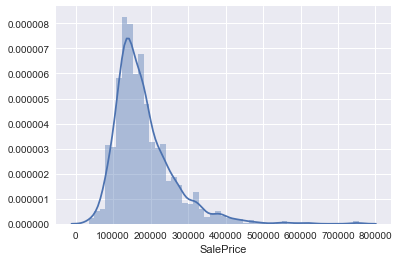

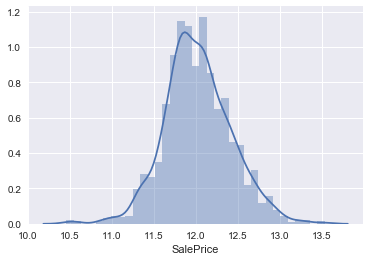

In [265]:
# view distribution of SalePrice
sns.distplot(full_df.SalePrice[full_df.SalePrice.notnull()])
plt.show()
# highly positively skewed, use log transformation to transform
# values and make it more normal
# since there is no negative values for saleprice,
# we can use a simple log transformation

sns.distplot(full_df.SalePrice[full_df.SalePrice.notnull()].apply(lambda x: np.log(x)))
plt.show()

In [266]:
# transform value
full_df.loc[full_df.SalePrice.notnull(), 'SalePrice'] = full_df.SalePrice[full_df.SalePrice.notnull()].apply(lambda x: np.log(x))

## Feature Selection

In [267]:
# create dataframe only containing numeric variables
numeric_df = full_df.select_dtypes(exclude = ['object'])


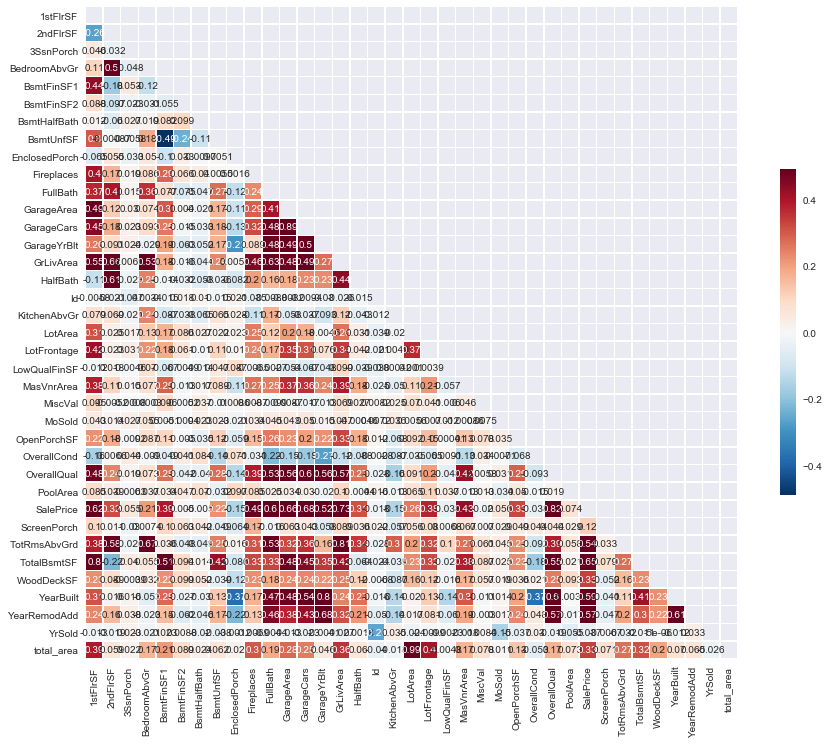

In [268]:
# correlation matrix
num_corr = numeric_df.corr()

# create a heatmap to see which values are correlated
mask = np.zeros_like(num_corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15,12))

sns.heatmap(num_corr, vmax = 0.3, square =True, annot = True,
           mask = mask, center = 0, linewidths = 0.5,
           cbar_kws = {'shrink': 0.5})

In [269]:
# also view corr values with each variable
corr_vals = [numeric_df.SalePrice.corr(numeric_df[i]) for i in numeric_df.columns]

In [270]:
corr_df = pd.DataFrame({'vars': numeric_df.columns, 'corr': corr_vals})
corr_df.sort_values('corr', ascending = False)

,corr,vars
28,1.000000,SalePrice
26,0.821350,OverallQual
14,0.725024,GrLivArea
12,0.681058,GarageCars
11,0.656230,GarageArea
31,0.648761,TotalBsmtSF
0,0.620394,1stFlrSF
10,0.595697,FullBath
33,0.587484,YearBuilt
34,0.565697,YearRemodAdd


From the correlation graph above alone, we can see that the target (SalePrice) is highly correlated with area related variables such as living area or garage area. It is also the most highly correlated with OverallQuality of the listing.

# 5. Modeling

## Dummifying categorical variables

In [271]:
# use pd.get_dummies to make categorical variables as numerics
full_df_dummies = pd.get_dummies(full_df)

## Separating back the train test set

In [272]:
# Separate train and test data back based on null saleprice
test = full_df_dummies[full_df_dummies.SalePrice.isnull()]
train = full_df_dummies[full_df_dummies.SalePrice.notnull()]

# drop the 'SalePrice' column in test set
test = test.drop('SalePrice', axis = 1)

# drop id columns from both
train = train.drop('Id', axis = 1)
test = test.drop('Id', axis = 1)

In [273]:
# split train to X and y
X = train.drop('SalePrice', axis = 1)
y = train['SalePrice']

## Modeling with regularized linear regression models

In [274]:
# import necessary libraries
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

# note that cross_val_score has pre-defined scoring methods, but no rmse exists
# thus the result should be gained by square rooting the negative of the result

### Ridge

In [275]:
ridge_model = RidgeCV(alphas = [0.05,0.1,0.3,1,3,5,10,15,30,50,75]).fit(X,y)
ridge_rmse = np.sqrt(-cross_val_score(model_lasso, X, y, 
                         scoring = 'neg_mean_squared_error',cv = 5))

/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

In [276]:
np.mean(ridge_rmse)

0.1120218954117366

### Lasso

In [277]:
lasso_model = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X,y)
lasso_rmse = np.sqrt(-cross_val_score(model_lasso, X, y, 
                         scoring = 'neg_mean_squared_error',cv = 5))

/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

In [278]:
np.mean(lasso_rmse)

0.1120218954117366

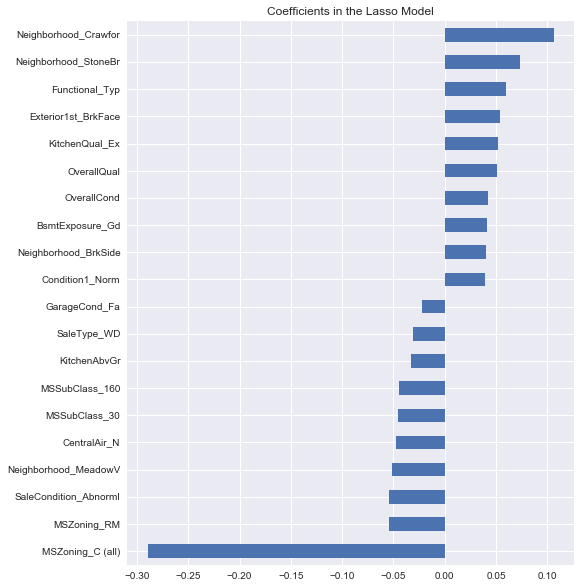

In [279]:
# view most important and least coefficeint
coef = pd.Series(lasso_model.coef_, index = X.columns)
imp_coef = pd.concat([coef.sort_values().head(10),
          coef.sort_values().tail(10)])

plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### Elasticnet

In [280]:
eln_model = ElasticNetCV(alphas = [1, 0.1, 0.001, 0.0005],
                        l1_ratio = [.1, .5, .7, .9, .95, .99, 1]).fit(X,y)
eln_rmse = np.sqrt(-cross_val_score(eln_model, X, y, 
                         scoring = 'neg_mean_squared_error',cv = 5))

/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

In [281]:
np.mean(eln_rmse)

0.11210669178358848

# 6. Submission

In [282]:
from sklearn.metrics import mean_squared_error

# training prediction
train_pred = model_lasso.predict(X)
# final training prediction
print(np.sqrt(mean_squared_error(y,train_pred)))

0.0996065792645


In [283]:
# untransform data to submit to kaggle
# since a log transformation was made, I apple exponential
test_pred = np.exp(model_lasso.predict(test.values))

In [284]:
submission = pd.DataFrame()
submission['Id'] = test_id
submission['SalePrice'] = test_pred

In [285]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
Id           1459 non-null int64
SalePrice    1459 non-null float64
dtypes: float64(1), int64(1)
memory usage: 22.9 KB


In [286]:
# submission.to_csv("submission_final.csv",index = False)